In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# cd /content/drive/MyDrive/LABis/image-segmentation-keras

[Errno 2] No such file or directory: '/content/drive/MyDrive/LABis/image-segmentation-keras'
/content


In [ ]:
# !python setup.py install

In [3]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2

from tqdm.notebook import tqdm

In [4]:
data_path = '/content/drive/MyDrive/LABis/dataset'

In [6]:
data_dir = data_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


In [7]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

num_classes = 32
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

(1000, 3)


KMeans(n_clusters=32)

/content/drive/MyDrive/LABis/dataset/train/2560.png


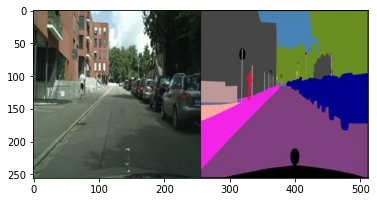

In [8]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

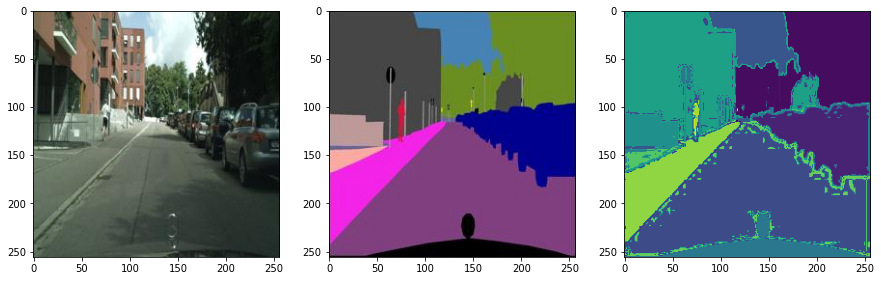

In [11]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [31]:
for file in os.listdir('/content/drive/MyDrive/LABis/dataset/train/'):
  filename = os.fsdecode(file)
  if filename.endswith(".png"):
    img = cv2.imread('/content/drive/MyDrive/LABis/dataset/train/'+filename)
    original = img[:256, :256, :]
    cropped = img[:256, 256:, :]
    anno = label_model.predict(cropped.reshape(-1,3)).reshape(256,256)
    cv2.imwrite('/content/drive/MyDrive/LABis/dataset/new_train/annotations/'+filename, anno)
    cv2.imwrite('/content/drive/MyDrive/LABis/dataset/new_train/images/'+filename, original)

In [32]:
for file in os.listdir('/content/drive/MyDrive/LABis/dataset/val/'):
  filename = os.fsdecode(file)
  if filename.endswith(".png"):
    img = cv2.imread('/content/drive/MyDrive/LABis/dataset/val/'+filename)
    original = img[:256, :256, :]
    cropped = img[:256, 256:, :]
    anno = label_model.predict(cropped.reshape(-1,3)).reshape(256,256)
    cv2.imwrite('/content/drive/MyDrive/LABis/dataset/new_val/annotations/'+filename, anno)
    cv2.imwrite('/content/drive/MyDrive/LABis/dataset/new_val/images/'+filename, original)

In [48]:
for file in os.listdir('/content/drive/MyDrive/LABis/dataset/test/'):
  filename = os.fsdecode(file)
  if filename.endswith(".png"):
    img = cv2.imread('/content/drive/MyDrive/LABis/dataset/test/'+filename)
    original = img[:256, :256, :]
    cropped = img[:256, 256:, :]
    anno = label_model.predict(cropped.reshape(-1,3)).reshape(256,256)
    cv2.imwrite('/content/drive/MyDrive/LABis/dataset/new_test/annotations/'+filename, anno)
    cv2.imwrite('/content/drive/MyDrive/LABis/dataset/new_test/images/'+filename, original)

In [51]:
print("Train set")
print(len(os.listdir('/content/drive/MyDrive/LABis/dataset/new_train/images/')))
print(len(os.listdir('/content/drive/MyDrive/LABis/dataset/new_train/annotations/')))
print("Test set")
print(len(os.listdir('/content/drive/MyDrive/LABis/dataset/new_test/images/')))
print(len(os.listdir('/content/drive/MyDrive/LABis/dataset/new_test/annotations/')))
print("Validation set")
print(len(os.listdir('/content/drive/MyDrive/LABis/dataset/new_val/images/')))
print(len(os.listdir('/content/drive/MyDrive/LABis/dataset/new_val/annotations/')))

Train set
2975
2975
Test set
400
400
Validation set
100
100


In [ ]:
! pip install git+https://github.com/divamgupta/image-segmentation-keras

In [25]:
from keras_segmentation.models.unet import mobilenet_unet

model = mobilenet_unet(n_classes=32 ,  input_height=256, input_width=256)


17235968/17225924 [==============================] - 1s 0us/step


EarlyStopping, ModelCheckpoint 구현가능

Custom callback을 만들어서 진행했음 

In [69]:
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoints_path = "/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet"

callbacks = [
    ModelCheckpoint(
                monitor = 'val_loss',
                mode = 'min',
                filepath = checkpoints_path + ".{epoch:05d}",
                save_weights_only = True,
                verbose=True
            ),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)      
]

In [96]:
checkpoints_path = "/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet"

model = mobilenet_unet(n_classes=32 ,  input_height=256, input_width=256)

callbacks = [
    ModelCheckpoint(
                monitor = 'val_loss',
                mode = 'min',
                filepath = checkpoints_path + ".{epoch:05d}",
                save_weights_only = True,
                verbose=True
            ),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)      
]

model.train(
    train_images =  "/content/drive/MyDrive/LABis/dataset/new_train/images/",
    train_annotations = "/content/drive/MyDrive/LABis/dataset/new_train/annotations/",
    validate = True,
    val_batch_size = 2,
    val_images = "/content/drive/MyDrive/LABis/dataset/new_val/images/",
    val_annotations = "/content/drive/MyDrive/LABis/dataset/new_val/annotations/",
    optimizer_name = keras.optimizers.Adam(learning_rate = 0.001), 
    batch_size = 2,
    callbacks = callbacks,
    epochs = 20
)

Verifying training dataset


100%|██████████| 2975/2975 [00:20<00:00, 148.18it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 100/100 [00:00<00:00, 148.16it/s]


Dataset verified! 
Epoch 1/20
511/512 [============================>.] - ETA: 0s - loss: 0.9561 - accuracy: 0.7286
Epoch 1: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00001
512/512 [==============================] - 44s 81ms/step - loss: 0.9566 - accuracy: 0.7285 - val_loss: 0.9469 - val_accuracy: 0.7426
Epoch 2/20
511/512 [============================>.] - ETA: 0s - loss: 0.7868 - accuracy: 0.7697
Epoch 2: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00002
512/512 [==============================] - 70s 137ms/step - loss: 0.7865 - accuracy: 0.7698 - val_loss: 0.8426 - val_accuracy: 0.7600
Epoch 3/20
511/512 [============================>.] - ETA: 0s - loss: 0.7325 - accuracy: 0.7830
Epoch 3: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00003
512/512 [==============================] - 39s 77ms/step - loss: 0.7324 - accuracy: 0.7831 - val_loss: 0.9172 - val_accuracy: 0.7315
Epoch 4/20
512/51

In [97]:
!python -m keras_segmentation evaluate_model \
 --checkpoints_path="/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet" \
 --images_path="/content/drive/MyDrive/LABis/dataset/new_test/images/" \
 --segs_path="/content/drive/MyDrive/LABis/dataset/new_test/annotations/"

2022-07-24 12:11:50.423251: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
loaded weights  /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00004
400it [00:34, 11.52it/s]
{'frequency_weighted_IU': 0.6446859153201736, 'mean_IU': 0.21218224784689113, 'class_wise_IU': array([7.49236746e-02, 1.70058425e-01, 3.41997264e-04, 2.58399217e-01,
       0.00000000e+00, 8.89059162e-02, 1.23010973e-01, 7.98339287e-01,
       3.58386278e-02, 1.77782751e-01, 0.00000000e+00, 1.07346133e-01,
       7.01342070e-01, 7.08833152e-03, 0.00000000e+00, 1.72750523e-01,
       1.05214249e-01, 6.74949252e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.57099698e-02, 2.72881591e-01,
       3.39346515e-01, 3.72178366e-01, 1.66736140e-03, 7.57228238e-01,
       7.50654106e-01, 0.00000000e+00, 7.83874355e-01, 0.00000000e+00])}


In [94]:
checkpoints_path = "/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet"

model = mobilenet_unet(n_classes=32 ,  input_height=256, input_width=256)

callbacks = [
    ModelCheckpoint(
                monitor = 'val_loss',
                mode = 'min',
                filepath = checkpoints_path + ".{epoch:05d}",
                save_weights_only = True,
                verbose=True
            ),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)      
]

model.train(
    train_images =  "/content/drive/MyDrive/LABis/dataset/new_train/images/",
    train_annotations = "/content/drive/MyDrive/LABis/dataset/new_train/annotations/",
    validate = True,
    val_batch_size = 4,
    val_images = "/content/drive/MyDrive/LABis/dataset/new_val/images/",
    val_annotations = "/content/drive/MyDrive/LABis/dataset/new_val/annotations/",

    optimizer_name = keras.optimizers.Adam(learning_rate = 0.001), 
    batch_size = 4,
    callbacks = callbacks,
    epochs = 20
)

Verifying training dataset


100%|██████████| 2975/2975 [00:20<00:00, 147.89it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 100/100 [00:00<00:00, 147.55it/s]


Dataset verified! 
Epoch 1/20
512/512 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.7562
Epoch 1: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00001
512/512 [==============================] - 75s 142ms/step - loss: 0.8486 - accuracy: 0.7562 - val_loss: 0.8510 - val_accuracy: 0.7524
Epoch 2/20
512/512 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.7931
Epoch 2: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00002
512/512 [==============================] - 71s 140ms/step - loss: 0.6929 - accuracy: 0.7931 - val_loss: 0.7835 - val_accuracy: 0.7670
Epoch 3/20
512/512 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.8112
Epoch 3: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00003
512/512 [==============================] - 72s 140ms/step - loss: 0.6250 - accuracy: 0.8112 - val_loss: 0.7912 - val_accuracy: 0.7651
Epoch 4/20
512/

In [95]:
!python -m keras_segmentation evaluate_model \
 --checkpoints_path="/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet" \
 --images_path="/content/drive/MyDrive/LABis/dataset/new_test/images/" \
 --segs_path="/content/drive/MyDrive/LABis/dataset/new_test/annotations/"

2022-07-24 12:05:56.460153: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
loaded weights  /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00004
400it [00:35, 11.33it/s]
{'frequency_weighted_IU': 0.6628875384361135, 'mean_IU': 0.22814992347942076, 'class_wise_IU': array([0.09737159, 0.24153897, 0.        , 0.37162471, 0.00143472,
       0.14642399, 0.15020118, 0.83883562, 0.03618292, 0.22365014,
       0.        , 0.1229962 , 0.74157286, 0.05182526, 0.        ,
       0.10600227, 0.11274618, 0.66154805, 0.        , 0.        ,
       0.        , 0.        , 0.05287356, 0.28438786, 0.28130431,
       0.56716336, 0.        , 0.7390499 , 0.72889836, 0.        ,
       0.74316553, 0.        ])}


In [92]:
checkpoints_path = "/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet"

model = mobilenet_unet(n_classes=32 ,  input_height=256, input_width=256)

callbacks = [
    ModelCheckpoint(
                monitor = 'val_loss',
                mode = 'min',
                filepath = checkpoints_path + ".{epoch:05d}",
                save_weights_only = True,
                verbose=True
            ),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)      
]

model.train(
    train_images =  "/content/drive/MyDrive/LABis/dataset/new_train/images/",
    train_annotations = "/content/drive/MyDrive/LABis/dataset/new_train/annotations/",
    validate = True,
    val_batch_size = 8,
    val_images = "/content/drive/MyDrive/LABis/dataset/new_val/images/",
    val_annotations = "/content/drive/MyDrive/LABis/dataset/new_val/annotations/",
    
    optimizer_name = keras.optimizers.Adam(learning_rate = 0.001), 
    batch_size = 8,
    callbacks = callbacks,
    epochs = 20
)

Verifying training dataset


100%|██████████| 2975/2975 [00:21<00:00, 140.44it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 100/100 [00:00<00:00, 146.93it/s]


Dataset verified! 
Epoch 1/20
512/512 [==============================] - ETA: 0s - loss: 0.7685 - accuracy: 0.7762
Epoch 1: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00001
512/512 [==============================] - 147s 282ms/step - loss: 0.7685 - accuracy: 0.7762 - val_loss: 0.8167 - val_accuracy: 0.7601
Epoch 2/20
512/512 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.8179
Epoch 2: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00002
512/512 [==============================] - 134s 261ms/step - loss: 0.5939 - accuracy: 0.8179 - val_loss: 0.7644 - val_accuracy: 0.7805
Epoch 3/20
512/512 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.8346
Epoch 3: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00003
512/512 [==============================] - 134s 262ms/step - loss: 0.5320 - accuracy: 0.8346 - val_loss: 0.7224 - val_accuracy: 0.7875
Epoch 4/20
5

In [93]:
!python -m keras_segmentation evaluate_model \
 --checkpoints_path="/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet" \
 --images_path="/content/drive/MyDrive/LABis/dataset/new_test/images/" \
 --segs_path="/content/drive/MyDrive/LABis/dataset/new_test/annotations/"

2022-07-24 11:55:52.689683: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
loaded weights  /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00006
400it [00:35, 11.40it/s]
{'frequency_weighted_IU': 0.698571238184423, 'mean_IU': 0.2586123256792936, 'class_wise_IU': array([0.15103779, 0.29528586, 0.00369748, 0.42634605, 0.        ,
       0.14113342, 0.2977269 , 0.85922853, 0.10572432, 0.20474304,
       0.        , 0.1492695 , 0.71916892, 0.02281834, 0.01563477,
       0.19956767, 0.1359322 , 0.71213472, 0.        , 0.        ,
       0.        , 0.        , 0.15180846, 0.35258885, 0.36519393,
       0.56098103, 0.01284625, 0.77481647, 0.79859785, 0.        ,
       0.81931207, 0.        ])}


In [98]:
checkpoints_path = "/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet"

model = mobilenet_unet(n_classes=32 ,  input_height=256, input_width=256)

callbacks = [
    ModelCheckpoint(
                monitor = 'val_loss',
                mode = 'min',
                filepath = checkpoints_path + ".{epoch:05d}",
                save_weights_only = True,
                verbose=True
            ),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)      
]

model.train(
    train_images =  "/content/drive/MyDrive/LABis/dataset/new_train/images/",
    train_annotations = "/content/drive/MyDrive/LABis/dataset/new_train/annotations/",
    validate = True,
    val_batch_size = 16,
    val_images = "/content/drive/MyDrive/LABis/dataset/new_val/images/",
    val_annotations = "/content/drive/MyDrive/LABis/dataset/new_val/annotations/",
    
    optimizer_name = keras.optimizers.Adam(learning_rate = 0.001), 
    batch_size = 16,
    callbacks = callbacks,
    epochs = 20
)

Verifying training dataset


100%|██████████| 2975/2975 [00:20<00:00, 143.90it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 100/100 [00:00<00:00, 148.18it/s]


Dataset verified! 
Epoch 1/20
512/512 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.7966
Epoch 1: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00001
512/512 [==============================] - 257s 497ms/step - loss: 0.6856 - accuracy: 0.7966 - val_loss: 0.8391 - val_accuracy: 0.7596
Epoch 2/20
512/512 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.8429
Epoch 2: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00002
512/512 [==============================] - 253s 495ms/step - loss: 0.5004 - accuracy: 0.8429 - val_loss: 0.7286 - val_accuracy: 0.7843
Epoch 3/20
512/512 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.8595
Epoch 3: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00003
512/512 [==============================] - 252s 493ms/step - loss: 0.4390 - accuracy: 0.8595 - val_loss: 0.7402 - val_accuracy: 0.7846
Epoch 4/20
5

In [99]:
!python -m keras_segmentation evaluate_model \
 --checkpoints_path="/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet" \
 --images_path="/content/drive/MyDrive/LABis/dataset/new_test/images/" \
 --segs_path="/content/drive/MyDrive/LABis/dataset/new_test/annotations/"

2022-07-24 12:32:45.657990: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
loaded weights  /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00004
400it [00:33, 11.79it/s]
{'frequency_weighted_IU': 0.7033913473407958, 'mean_IU': 0.2629095356894042, 'class_wise_IU': array([0.19731526, 0.33384224, 0.00935829, 0.43522499, 0.00846262,
       0.16095091, 0.30602086, 0.860191  , 0.08053005, 0.17998735,
       0.        , 0.16834401, 0.7332528 , 0.03649714, 0.00758534,
       0.24774167, 0.12126886, 0.72012919, 0.        , 0.        ,
       0.        , 0.        , 0.1195831 , 0.32996447, 0.33723775,
       0.57461081, 0.04546788, 0.78466893, 0.80216719, 0.        ,
       0.81270242, 0.        ])}


In [100]:
checkpoints_path = "/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet"

model = mobilenet_unet(n_classes=32 ,  input_height=256, input_width=256)

callbacks = [
    ModelCheckpoint(
                monitor = 'val_loss',
                mode = 'min',
                filepath = checkpoints_path + ".{epoch:05d}",
                save_weights_only = True,
                verbose=True
            ),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)      
]

model.train(
    train_images =  "/content/drive/MyDrive/LABis/dataset/new_train/images/",
    train_annotations = "/content/drive/MyDrive/LABis/dataset/new_train/annotations/",
    validate = True,
    val_batch_size = 16,
    val_images = "/content/drive/MyDrive/LABis/dataset/new_val/images/",
    val_annotations = "/content/drive/MyDrive/LABis/dataset/new_val/annotations/",
    
    optimizer_name = keras.optimizers.Adam(learning_rate = 0.01), 
    batch_size = 16,
    callbacks = callbacks,
    epochs = 20
)

Verifying training dataset


100%|██████████| 2975/2975 [00:20<00:00, 143.94it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 100/100 [00:00<00:00, 148.92it/s]


Dataset verified! 
Epoch 1/20
512/512 [==============================] - ETA: 0s - loss: 0.8046 - accuracy: 0.7639
Epoch 1: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00001
512/512 [==============================] - 257s 498ms/step - loss: 0.8046 - accuracy: 0.7639 - val_loss: 0.9737 - val_accuracy: 0.7221
Epoch 2/20
512/512 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.8068
Epoch 2: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00002
512/512 [==============================] - 253s 495ms/step - loss: 0.6281 - accuracy: 0.8068 - val_loss: 1.0329 - val_accuracy: 0.6863
Epoch 3/20
512/512 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.8244
Epoch 3: saving model to /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00003
512/512 [==============================] - 255s 498ms/step - loss: 0.5665 - accuracy: 0.8244 - val_loss: 0.7706 - val_accuracy: 0.7694
Epoch 4/20
5

In [101]:
!python -m keras_segmentation evaluate_model \
 --checkpoints_path="/content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet" \
 --images_path="/content/drive/MyDrive/LABis/dataset/new_test/images/" \
 --segs_path="/content/drive/MyDrive/LABis/dataset/new_test/annotations/"

2022-07-24 12:58:25.717514: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
loaded weights  /content/drive/MyDrive/LABis/mobilenet_unet_1/mobilenet_unet.00005
400it [00:34, 11.69it/s]
{'frequency_weighted_IU': 0.6660453885923403, 'mean_IU': 0.23863543050848832, 'class_wise_IU': array([0.0814053 , 0.286249  , 0.00665115, 0.35062542, 0.00572246,
       0.1492358 , 0.22207955, 0.84042103, 0.07025521, 0.18240874,
       0.        , 0.09972177, 0.75955562, 0.05385483, 0.00190517,
       0.13674346, 0.1579491 , 0.65985446, 0.        , 0.        ,
       0.        , 0.        , 0.15044687, 0.31917129, 0.32320863,
       0.55392005, 0.01827742, 0.71541751, 0.74289224, 0.        ,
       0.74836169, 0.        ])}


#optimal
optimizer = Adam, batch_size = 16, learning rate = 0.001